In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from scipy import stats as st
from census import Census
from config import api_key
c = Census(api_key, year=2017)
#!pip install census
Medicare_file = "medicare_charges.csv"

In [2]:
census_data = c.acs5.get(("NAME", "B19013_001E", 
                          "B01003_001E", 
                          "B01002_001E",
                          "B19301_001E",
                          "B17001_002E",
                          "B23025_005E",
                         "B25077_001E",
                         "B15003_022E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_005E": "Unemployment Count",
                                      "B25077_001E": "Median Home Value",
                                      "B15003_022E": "Bachelor Count",
                                      "NAME": "Name", "zip code tabulation area": "Zip Code"})
Census_Cleaned = census_pd[["Population",
                            "Median Age",
                            "Per Capita Income",
                            "Zip Code"]]
Census_Cleaned = Census_Cleaned.dropna()
Census_Cleaned.head(10)

,Population,Median Age,Per Capita Income,Zip Code
0,17599.0,38.9,7041.0,00601
1,39209.0,40.9,8978.0,00602
2,50135.0,40.4,10897.0,00603
3,6304.0,42.8,5960.0,00606
4,27590.0,41.4,9266.0,00610
5,62566.0,41.4,10283.0,00612
6,10687.0,43.7,9002.0,00616
7,24508.0,38.7,8762.0,00617
8,7405.0,48.4,11935.0,00622
9,42321.0,41.3,9101.0,00623


In [3]:
print(len(Census_Cleaned["Zip Code"]))


32795


In [4]:
Medicare_Cost_df = pd.read_csv(Medicare_file)
Medicare_Cost_Cleaned = Medicare_Cost_df[["Provider Zip Code",
                                          "Provider State", 
                                          "DRG Definition", 
                                          "Average Total Payments"]]
Medicare_Cost_Cleaned = Medicare_Cost_Cleaned.rename(columns = {"Provider Zip Code":"Zip Code",
                                                               "Provider State":"State",
                                                               "DRG Definition":"Procedure",
                                                               "Average Total Payments": "Cost"})
Medicare_Cost_df.head()
#print(len(Medicare_Cost_df))

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,023 - CRANIOTOMY W MAJOR DEVICE IMPLANT OR ACU...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,28,117117.78570,25823.714290,24057.392860
1,025 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL P...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,32,98357.56250,20688.343750,19791.406250
2,027 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL P...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,11,69153.54546,11811.181820,8194.363636
3,037 - EXTRACRANIAL PROCEDURES W MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,12,100427.33330,19134.000000,18154.000000
4,038 - EXTRACRANIAL PROCEDURES W CC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,17,58199.47059,8519.470588,6714.882353


In [5]:
Medicare_Cost_Cleaned = Medicare_Cost_Cleaned[Medicare_Cost_Cleaned.State == "CA"]
Medicare_Cost_871 = Medicare_Cost_Cleaned[Medicare_Cost_Cleaned.Procedure == "871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W MCC"]
Medicare_Cost_871 = Medicare_Cost_871.groupby("Zip Code").mean()
Medicare_Cost_871["Zip Code"] = Medicare_Cost_871.index
#Medicare_Cost_871reset_index(drop = True , inplace = True)


Medicare_Cost_Total = Medicare_Cost_871.rename(columns = {"Cost":"Total Avg 871"})

#Medicare_Cost_Total["Total Avg 871] = Medicare_Cost_Cleaned[Medicare_Cost_Cleaned.Procedure == "871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W MCC"].groupby("Zip Code").mean()["Cost"]
Medicare_Cost_Total["Total Avg 291"] = round(Medicare_Cost_Cleaned[Medicare_Cost_Cleaned.Procedure == "291 - HEART FAILURE & SHOCK W MCC"].groupby("Zip Code").mean()["Cost"], 0)
Medicare_Cost_Total["Total Avg 872"] = round(Medicare_Cost_Cleaned[Medicare_Cost_Cleaned.Procedure == "872 - SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W/O MCC"].groupby("Zip Code").mean()["Cost"], 0)
Medicare_Cost_Total["Total Avg 470"] = round(Medicare_Cost_Cleaned[Medicare_Cost_Cleaned.Procedure == "470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC"].groupby("Zip Code").mean()["Cost"], 0)
Medicare_Cost_Total["Total Avg 392"] = round(Medicare_Cost_Cleaned[Medicare_Cost_Cleaned.Procedure == "392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC"].groupby("Zip Code").mean()["Cost"], 0)

Medicare_Cost_Total["Total Avg 871"] = round(Medicare_Cost_Total["Total Avg 871"], 0)

Medicare_Cost_Total = Medicare_Cost_Total.dropna()
Medicare_Cost_Total.reset_index(drop = True , inplace = True)
Medicare_Cost_Total


,Total Avg 871,Zip Code,Total Avg 291,Total Avg 872,Total Avg 470,Total Avg 392
0,22186.0,90015,19343.0,15902.0,24933.0,13643.0
1,16187.0,90017,13153.0,9645.0,18058.0,7357.0
2,17438.0,90027,13887.0,9169.0,19586.0,8709.0
3,15828.0,90028,12988.0,9306.0,17425.0,7162.0
4,26463.0,90033,23416.0,16866.0,21003.0,14192.0
...,...,...,...,...,...,...
180,13586.0,95966,11342.0,8155.0,15967.0,6020.0
181,13512.0,95969,11305.0,8972.0,15886.0,5872.0
182,14966.0,96001,12310.0,8846.0,16913.0,6521.0
183,16009.0,96080,13438.0,9235.0,18595.0,8787.0


In [6]:
top5 = Medicare_Cost_Cleaned.Procedure.value_counts()
top5.head()

871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W MCC                    277
291 - HEART FAILURE & SHOCK W MCC                                           260
872 - SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W/O MCC                  258
470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC    236
392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC                228
Name: Procedure, dtype: int64

In [7]:
Census_Cleaned["Zip Code"] = Census_Cleaned["Zip Code"].astype(int)
Medicare_Cost_Total["Zip Code"] = Medicare_Cost_Total["Zip Code"].astype(int)
Data = pd.merge(Medicare_Cost_Total, Census_Cleaned, how="inner", on="Zip Code")
Data = Data.drop([8])
Data.head()

,Total Avg 871,Zip Code,Total Avg 291,Total Avg 872,Total Avg 470,Total Avg 392,Population,Median Age,Per Capita Income
0,22186.0,90015,19343.0,15902.0,24933.0,13643.0,20187.0,32.4,31423.0
1,16187.0,90017,13153.0,9645.0,18058.0,7357.0,26390.0,30.8,21874.0
2,17438.0,90027,13887.0,9169.0,19586.0,8709.0,45616.0,38.0,46196.0
3,15828.0,90028,12988.0,9306.0,17425.0,7162.0,31054.0,34.4,32587.0
4,26463.0,90033,23416.0,16866.0,21003.0,14192.0,48841.0,30.0,13332.0


In [8]:
Data["Total"] = Data["Total Avg 871"] + Data["Total Avg 291"] + Data["Total Avg 872"] + Data["Total Avg 470"] + Data["Total Avg 392"]

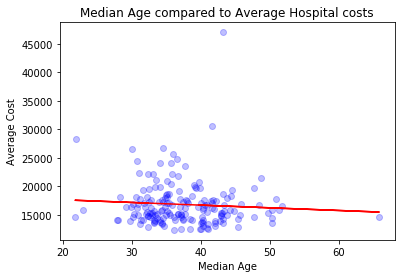

In [9]:
def Scatter (x, y):
    slope, intercept, r, p, std_err = st.linregress(Data[x], Data[y])
    plt.scatter(Data[x], Data[y], marker="o", color="blue", alpha = 0.25)
    plt.xlabel(x)
    plt.title(f"{x} compared to Average Hospital costs")
    plt.ylabel("Average Cost")
    PCI_Line = slope* Data[x] + intercept
    plt.plot(Data[x], PCI_Line, "r-")
    
    
    
    total_y = Data.iloc[:,1]
    total_x = Data.iloc[:,8]
    corr = st.pearsonr(total_x, total_y)
    #plt.annotate(f"The r value is {round(corr[0], 2)}", ,fontsize=15,color="b")
    #plt.annotate(f"The p value is {round(corr[1], 2)}",loc = "best",fontsize=15,color="b")
    
    plt.show
Scatter_Age_871 = Scatter("Median Age", "Total Avg 871")
plt.savefig("Scatter_Age_871.PNG")

In [10]:
st.pearsonr?

In [11]:
Scatter_PCI = Scatter("Per Capita Income")
plt.savefig("Scatter_PCI.PNG")

TypeError: Scatter() missing 1 required positional argument: 'y'

In [ ]:
Scatter_Pop = Scatter("Population")
plt.savefig("Scatter_Pop.PNG")

In [ ]:
slope

In [ ]:
###Scatter & Linear Regress lines for Data
###Box Plot for Data
###Presentation
###Correlation Coeffecients
###
###

In [ ]:
total_871proc = Data.iloc[:,1]
median_age = Data.iloc[:,8]
corr_871proc_age = st.pearsonr(median_age, total_871proc)
print(round(corr_871proc_age[0],2))

In [ ]:
total_291proc = Data.iloc[:,3]
median_age = Data.iloc[:,8]
corr_291proc_age = st.pearsonr(median_age, total_291proc)
print(round(corr_291proc_age[0],2))

In [ ]:
total_872proc = Data.iloc[:,4]
median_age = Data.iloc[:,8]
corr_872proc_age = st.pearsonr(median_age, total_872proc)
print(round(corr_872proc_age[0],2))

In [ ]:
total_470proc = Data.iloc[:,5]
median_age = Data.iloc[:,8]
corr_470proc_age = st.pearsonr(median_age, total_470proc)
print(round(corr_470proc_age[0],2))

In [ ]:
total_392proc = Data.iloc[:,6]
median_age = Data.iloc[:,8]
corr_392proc_age = st.pearsonr(median_age, total_392proc)
print(round(corr_392proc_age[0],2))

In [ ]:
population = Data.iloc[:,7]
corr_871proc_pop = st.pearsonr(population, total_871proc)
print(round(corr_871proc_pop[0],2))

In [ ]:
population = Data.iloc[:,7]
corr_291proc_pop = st.pearsonr(population, total_291proc)
print(round(corr_291proc_pop[0],2))

In [ ]:
population = Data.iloc[:,7]
corr_872proc_pop = st.pearsonr(population, total_872proc)
print(round(corr_872proc_pop[0],2))

In [ ]:
population = Data.iloc[:,7]
corr_470proc_pop = st.pearsonr(population, total_470proc)
print(round(corr_470proc_pop[0],2))

In [ ]:
population = Data.iloc[:,7]
corr_392proc_pop = st.pearsonr(population, total_392proc)
print(round(corr_392proc_pop[0],2))

In [ ]:
capita_income = Data.iloc[:,9]
corr_871proc_income = st.pearsonr(capita_income, total_871proc)
print(round(corr_871proc_income[0],2))

In [ ]:
capita_income = Data.iloc[:,9]
corr_291proc_income = st.pearsonr(capita_income, total_291proc)
print(round(corr_291proc_income[0],2))

In [ ]:
capita_income = Data.iloc[:,9]
corr_872proc_income = st.pearsonr(capita_income, total_872proc)
print(round(corr_872proc_income[0],2))

In [ ]:
capita_income = Data.iloc[:,9]
corr_470proc_income = st.pearsonr(capita_income, total_470proc)
print(round(corr_470proc_income[0],2))

In [ ]:
st.ttest_ind(total_871proc, median_age)

In [ ]:
st.ttest_ind(total_871proc, population)

In [ ]:
st.ttest_ind(total_871proc, capita_income)

In [ ]:
st.ttest_ind(total_291proc, median_age)

In [ ]:
st.ttest_ind(total_291proc, population)

In [ ]:
st.ttest_ind(total_291proc, capita_income)

In [ ]:
st.ttest_ind(total_872proc, median_age)

In [ ]:
st.ttest_ind(total_872proc, population)

In [ ]:
st.ttest_ind(total_872proc, capita_income)

In [ ]:
st.ttest_ind(total_470proc, median_age)

In [ ]:
st.ttest_ind(total_470proc, population)

In [ ]:
st.ttest_ind(total_470proc, capita_income)